A multilayer perceptron (MLP) is a fully connected neural network. As such, all the nodes from one layer are connected to the next layer. Any MLP consists of three layers or more. The minimum three layers are: 1) an input layer, 2) an output layer, and 3) one (or more) hidden layers.

In [1]:
##
# LOAD THE NECESSARY LIBRARIES AND MODULES
##

import numpy as np # NumPy is the fundamental package for scientific computing in Python

import scipy as sc # SciPy is a collection of mathematical algorithms and convenience functions built on the NumPy extension of Python

import matplotlib.pyplot as plt # We will use this for Visualization

from sklearn.datasets import make_circles # We will use this to buld the dataset

import time # Handles time-related tasks

from IPython.display import clear_output # We use this to clear the output of a cell


We will start by building some data using the function `make_circles` ([click here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html)). This function makes a large circle containing a smaller circle in two dimensions. The idea is to produce a a simple toy dataset that we can use to visualize clustering and classification algorithms.

Shape of the input:  (600, 2)
Shape of the output: (600, 1)


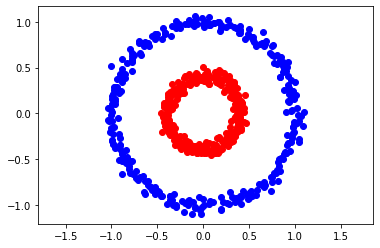

In [2]:
##
# BUILD SOME DATA
##

no_examples   = 600
no_attributes = 2

# X: input vector, Y: output vector (the desired Y values are unique and binary):
X, Y = make_circles(n_samples = no_examples, factor = 0.4, noise = 0.04)

# For all entries, create a single output (only one dimension):
Y = Y[:, np.newaxis]

# X: 600 entries, with two attributes each:
print(f'Shape of the input:  {X.shape}')

# Y: Each entry has a single, binary output:
print(f'Shape of the output: {Y.shape}')

# Plot the data that we just created:
plt.scatter(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], c="blue") # Y == 0 (blue dots)
plt.scatter(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], c="red")  # Y == 1 (red dots)
plt.axis("Equal")
plt.show()

Now that we have some data to toy with, we will start buil d a new class to code the neural network. Make sure to check Python's documentation on Classes if you need to refresh your memory about how they work ([click here](https://docs.python.org/3/tutorial/classes.html)).

In [3]:
##
# CREATE A NEW CLASS
##

# The Class will let us create different covers:
class neuronal_cover():

# This is our random initialization for the new Class:
  def __init__ (self, n_conex, n_neur, activ_func):
    self.activ_func = activ_func # Activation function (a non-linear function)
    self.n_neur     = n_neur
    self.n_conex    = n_conex
    self.b = np.random.rand(1, n_neur) * 2 - 1 # b = bias (vector)
    self.W = np.random.rand(n_conex, n_neur) * 2 -1 # W = weight (matrix)


Newxt we need to define an **activation function**. In MLP, the activation fucntion is always non-linear. The multiple layers and non-linear activation distinguish MLP from a linear perceptron. It is beceuase of that that MLP can distinguish data that is not linearly separable.

Remember that an MLP consists of at least three layers of nodes: an input layer, a hidden layer (but there can be more than one hidden layers), and an output layer. Except for the input nodes, each node is a **neuron** that uses a nonlinear activation function.

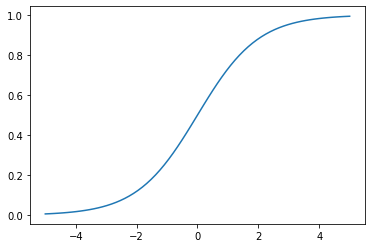

In [4]:
##
# DEFINE THE ACTIVATION FUNCTION
##

# Let us define a non-linear function for activation:
sigm = (lambda x: 1 / (1 + np.e ** (-x)),
        lambda x: x * (1-x))

_x = np.linspace(-5, 5, 70) # This is to return evenly spaced numbers over a specified interval.

plt.plot(_x, sigm[0](_x)) # Plot

We now have all the basic elements to start building our neural network. The next step is to crate a basic function that will start building that network for us.

In [5]:
##
# DEFINE A FUNCTION TO CREATE THE NEURONAL NETWORK
##

def creat_neuro_network (neur_layer, activ_func):
  # Store layers and their random parameters:
  neuro_network = []
  for i, layer in enumerate(neur_layer[:-1]): # [:-1] removed the last value from vector to avoid index error
    neuro_network.append(neuronal_cover(neur_layer[i], neur_layer[i+1], activ_func))
  return neuro_network

neur_layer = [no_attributes, 4, 4, 1] # 4 neurons per layer, with 4 layers
neuro_network = creat_neuro_network(neur_layer, sigm) # sigm is the non-linear activation function

print(f'Neuronal network architecture:\nLayer 0: Entry layer\n') 
for i, layer in enumerate(neuro_network):
  print(f'Layer {i+1}: \n {layer.n_conex} Connections received \n {layer.n_neur} Neurons')

Neuronal network architecture:
Layer 0: Entry layer

Layer 1: 
 2 Connections received 
 4 Neurons
Layer 2: 
 4 Connections received 
 4 Neurons
Layer 3: 
 4 Connections received 
 1 Neurons


We will need to measure the error rates comparing predicted and observed outputs. Note that the opbaserved outputs, in this case, come from the labeled input data that we created.

In [6]:
##
# DEFINE AN ERROR FUNCTION
##

error_function = (lambda Yd, Yp: np.mean((Yd - Yp) ** 2),
                 lambda Yd, Yp: (Yd - Yp)) # Yd: desired output; Yp: predicted output

MLP utilizes a **supervised learning** technique called **backpropagation** for training.

In [7]:

##
# DEFINE A TRAINING FUNCTION
##

def training(neuro_network, X, Y, error_function, learn_rate = 0.05, training = True):
  # Sum of weighted entries = X * W + b
  # We store the sum of weihted entries for each layer, starting from the entry layer where the input is X
  layer_output = [(None, X)]
  for i, layer in enumerate(neuro_network):
    # Each new entry is the output of the previous layer:
    sum_weighted_entries = layer_output[-1][1] @ neuro_network[i].W + neuro_network[i].b
    activation = neuro_network[i].activ_func[0](sum_weighted_entries)
    layer_output.append((sum_weighted_entries, activation))

  # Prapagation and gradient descent during training
  if training:
    errors = []
    for i in reversed(range(0, len(neuro_network))):
      # i start with 2
      # len(neuro_network) = 3
      # len(layer_output) = 4
      sum_weighted_entries = layer_output[i + 1][0]
      activation = layer_output[i + 1][1]
      
      # Calculate the error in the exit layer:
      if i == len(neuro_network) - 1:
        errors.insert(0, error_function[1](activation, Y) * neuro_network[i].activ_func[1](activation))

      # Calculate error in the hidden layers:
      # T = transposed
      else:
        # Error in the hidden layers depends on the error from the previous layer:
        errors.insert(0, errors[0] @ W_next.T * neuro_network[i].activ_func[1](activation)) # [0] refers to the last value that was added

      # Auxiliary variable that stores the weights from previous layer:
      W_next = neuro_network[i].W

      # Gradient descent: Parameter optmization that depends on the error from previous layer
      neuro_network[i].b = neuro_network[i].b - np.mean(errors[0], axis=0, keepdims=True) * learn_rate
      neuro_network[i].W = neuro_network[i].W - layer_output[i][1].T @ errors[0] * learn_rate

  # Returns activation values (1) from the last layer (-1) in the network (exit layer):
  return layer_output[-1][1]



Now we can execute our functions and measure the error aftar a certain number of iterations.

In this example, we will produce two graphics every 20 iterations. The first is to vizualize how the network is separating both classes (red and blue). The second is to observe the evolution of the error.

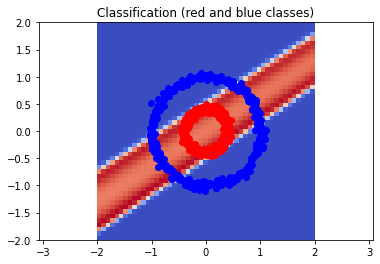

Iteraction 2780, MSE = 0.11494984063759406


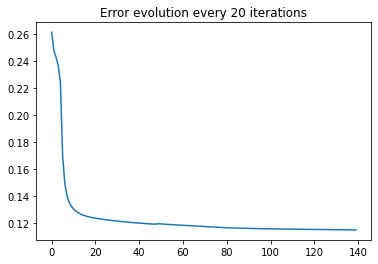

In [ ]:
##
# EXECUTE AND MEASURE THE ERROR
##

error = [] # Store the error
iterations = 2800 # Define the number of iterations

for i in range(iterations): # Training is repeated n times

  S = training(neuro_network, X, Y, error_function, learn_rate = 0.1) # We are calling the training function we defined above

  if i % 20 == 0: # Every 20 iterations
    error.append(error_function[0](S, Y)) # Append and store error

    resolution = 50
    dots_x = np.linspace(-2, 2, resolution) # generate 50 numbers between -2 and 2 for x
    dots_y = np.linspace(-2, 2, resolution) # generate 50 numbers between -2 and 2 for y

    output_validation = np.zeros((resolution, resolution)) # Returns a NxN matriz of zeros

    # Run 50 x 50 times every 20 iterations:
    for n_row, x in enumerate(dots_x):
      for n_column, y in enumerate(dots_y):
        output_validation[n_row, n_column] = training(neuro_network, np.array([[x, y]]), Y, error_function, training=False)[0][0]

    # First plot:
    plt.title("Classification (red and blue classes)")
    plt.pcolormesh(dots_x, dots_y, output_validation, cmap="coolwarm")
    plt.axis("equal")
    plt.scatter(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], c="blue")
    plt.scatter(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], c="red")
    clear_output(wait=True)
    plt.show()

    # Second plot:
    plt.title("Error evolution every 20 iterations")
    plt.plot(range(len(error)), error) # plot (x = no. calculated error, y = produced error)
    print(f'Iteraction {i}, MSE = {error[-1]}')
    plt.show()

    time.sleep(0.5)

